<a href="https://www.kaggle.com/code/syerramilli/ps3e23-eda-catboost-baseline-shap?scriptVersionId=145391683" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

The objective of this classification task is to predict whether a software module has one or more defects based on different measures on code and performance. There are two outcomes - `True` and `False`. Within this notebook, we perform some exploratory data analysis, feature selection, train a baseline catboost classification model (with class weighting), and compute feature importances through SHAP.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shap

from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import roc_auc_score, roc_curve


# hierarchical clustering
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from pathlib import Path

from typing import Optional, List, Dict, Tuple
from numbers import Number

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Loading the data

In [2]:
path = Path('/kaggle/input/playground-series-s3e23')

train = pd.read_csv(path / 'train.csv', index_col=['id'])
test = pd.read_csv(path / 'test.csv', index_col=['id'])

train.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [3]:
print(f'Number of observations in training set: {train.shape[0]}')
print(f'Number of observations in test set: {test.shape[0]}')

Number of observations in training set: 101763
Number of observations in test set: 67842


Here is a snapshot of the training data. From this, we can see the following:

1. There are 21 potential features, all of which are numerical. 
2. There are no missing values.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  uniq_Op

## Target

The goal of this binary classification task is to predict `defects` - whether or not the software module has one or more defects. The data has some class imbalance.

In [5]:
train['defects'].value_counts() / train.shape[0]

defects
False    0.773356
True     0.226644
Name: count, dtype: float64

## EDA on features

We first check if there is any feature for which its mode has more than 90% of the observations. It is unlikely that any model can reliably use such features. So, we will drop them

In [6]:
def get_mode_fraction(x:pd.Series) -> float:
    cts = x.value_counts(sort=True, ascending=False)
    return cts.iloc[0]/x.shape[0]

def filter_greater_than(series:pd.Series,threshold:Number) -> pd.Series:
    '''
    Returns series elements greater than threshold. This funtion can be
    used with the .pipe methods
    '''
    return series[series>threshold]

high_mode_per = (
    train.drop('defects', axis=1)
    .apply(get_mode_fraction)
    .pipe(filter_greater_than, threshold = 0.8)
)
high_mode_per

locCodeAndComment    0.919293
dtype: float64

In [7]:
# drop these columns
train = train.drop(high_mode_per.index.tolist(), axis=1)

Next, we check if there are any features that are skewed. It turns out all the features are postively skewed, with some being extremely so.

In [8]:
skewness = train.drop('defects', axis=1).skew().sort_values()
skewness

l               1.903337
i               4.859743
d               5.618081
uniq_Op         5.638689
ev(g)           6.513498
branchCount     8.568527
lOBlank         8.717378
n               9.908514
total_Opnd     10.496121
total_Op       11.149996
loc            11.818912
lOComment      12.086854
uniq_Opnd      13.504999
v(g)           14.258631
v              15.959869
lOCode         15.961574
b              16.016099
iv(g)          28.209964
t              46.363403
e              47.676446
dtype: float64

Although correcting the skew isn't needed for tree based models, it helps in visualizing the feature better. Therefore, we will apply a log1p transform to all the features.

In [9]:
numerical_cols= train.select_dtypes(include=['number']).columns.tolist()
train[numerical_cols] = train[numerical_cols].apply(np.log1p)
train = train.rename({col:f'log1p_{col}' for col in numerical_cols}, axis=1)

In the cell below, we plot the histograms of the transformed features. Clearly, some of the features have skewed distributions even after the log1p transformation. It turns out that a lot of features have a large number of 0 values. 

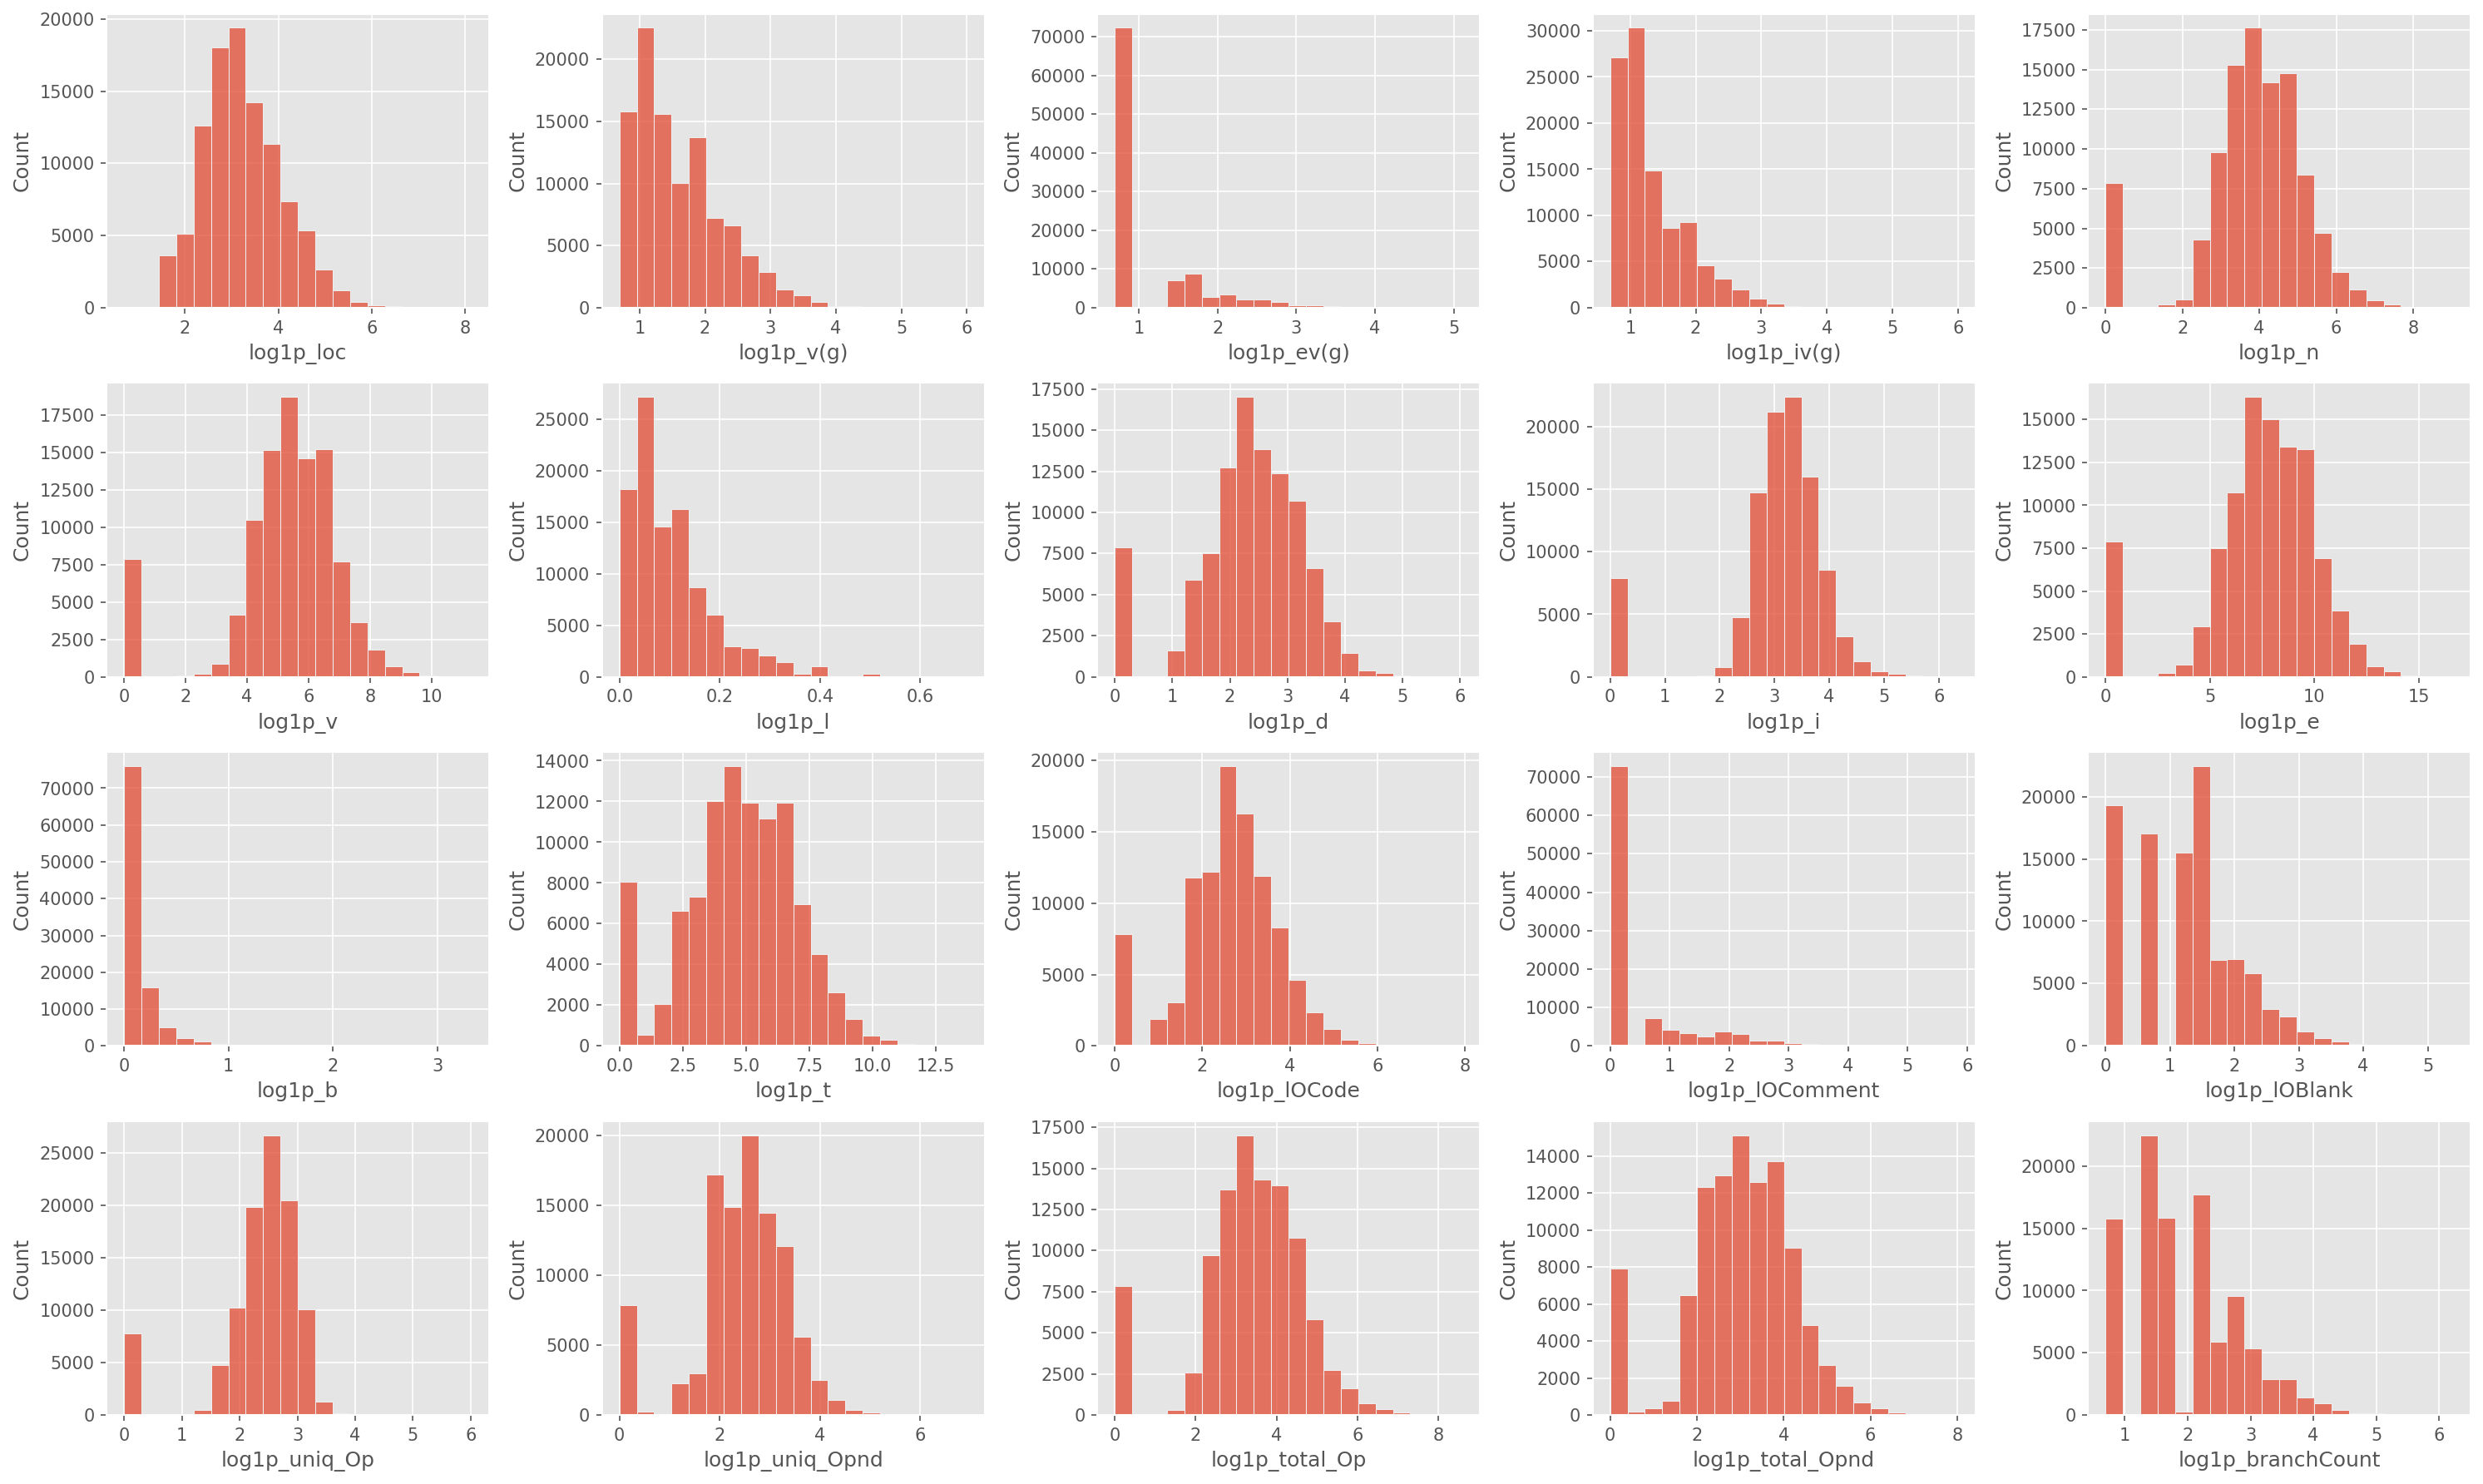

In [10]:
n_rows = 4
n_cols = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize = (4 * n_cols, 3 * n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        _ = sns.histplot(data=train, x=train.columns[n_cols * i + j], ax=axs[i,j], bins=20)
        
fig.tight_layout()

### Correlation analysis - hierarchical clustering

We now compute the Spearman rank correlations between pairs of the features, and drop ones which are highly correlated with each other. Since there are many columns, we will perform hierarchical clustering to cluster the features.

Hierarchical clustering arranges the data (in our case, features) using a dissimilarity (or distance) matrix. In our case, we compute the dissimilarity between two features $x_i$ and $x_j$  as
$$
    \large
    d(x_i,x_j) = 1 - |r(x_i, x_j)|,
$$
where $r(x_i, x_j)$ is the Spearman rank correlation between $x_1$ and $x_2$. The Spearman rank measures the degrees of monotonic dependence between two features. Values closer to +1 or -1 indicate a monotonically increasing or decreasing relationships respectively. So, the dissimilarity between two features will be close to 0 if they are nearly monotonic fuctions of each other. 

In [11]:
# construct correlation matrix
corr_matrix = train.drop('defects', axis=1).corr(method='spearman')

# hierarchical cluster based on the correlations
dissimilarity = 1 - abs(corr_matrix.values)

After computing the dissimilaity matrix, we then perform hierarchical clustering on the features. We can then visualize the hierarchy of relationships using a dendrogram plot, which displays a tree-like structure, with branches that represent the merging of similar features at different levels of dissimilarity. The leaves of the dendograms are the features.

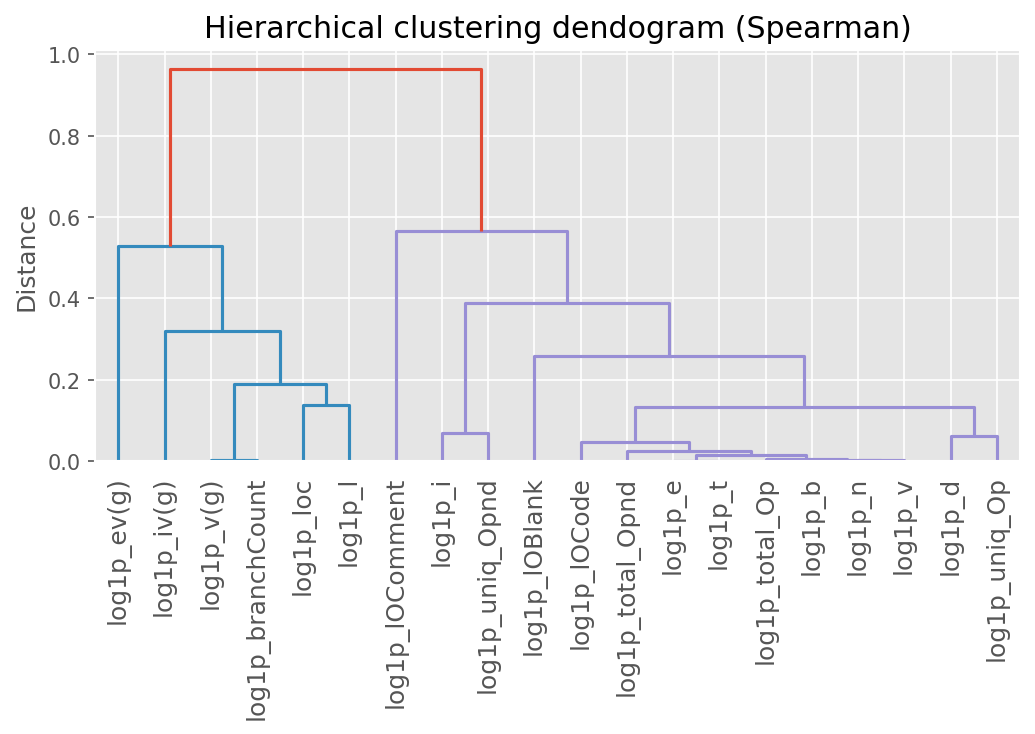

In [12]:
linkage_matrix = hierarchy.linkage(squareform(dissimilarity), method='complete')

# plot the dendogram
fig,ax = plt.subplots(1,1,figsize=(7,5))
dendogram = hierarchy.dendrogram(
    linkage_matrix, ax=ax, 
    labels=corr_matrix.columns.tolist(),
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set_ylabel('Distance')
_ = ax.set_title('Hierarchical clustering dendogram (Spearman)')
fig.tight_layout()

We will now generate the cluster labels for each feature. The number of clusters will depende on the distance we use a threshold. For smaller distance thresholds, more clusters will be formed. Here, we use a distance threshold of 0.15. 

In [13]:
# get the cluster labels
threshold = 0.15
cluster_labels = hierarchy.fcluster(linkage_matrix, threshold, criterion='distance')
n_clusters = np.unique(cluster_labels).shape[0]
print(f'Number of clusters: {n_clusters}\n')

cluster_features = {}

# show features within each cluster
for label in range(1, n_clusters + 1):
    print(f'Cluster {label}')
    
    leaves_in_cluster = cluster_labels == label
    cluster_features[label] = corr_matrix.columns[leaves_in_cluster].tolist()
    print(cluster_features[label])
    print()

Number of clusters: 8

Cluster 1
['log1p_v(g)', 'log1p_branchCount']

Cluster 2
['log1p_loc', 'log1p_l']

Cluster 3
['log1p_iv(g)']

Cluster 4
['log1p_ev(g)']

Cluster 5
['log1p_i', 'log1p_uniq_Opnd']

Cluster 6
['log1p_n', 'log1p_v', 'log1p_d', 'log1p_e', 'log1p_b', 'log1p_t', 'log1p_lOCode', 'log1p_uniq_Op', 'log1p_total_Op', 'log1p_total_Opnd']

Cluster 7
['log1p_lOBlank']

Cluster 8
['log1p_lOComment']



Finally, we will select only one feature from each cluster. 

In [14]:
numerical_features = []
for cols_in_cluster in cluster_features.values():
    numerical_features.append(cols_in_cluster[0])
    
train = train[numerical_features + ['defects']]

### Distributions by class

We now plot the boxplots of the selected features grouped by the different classes. It appears that all the features have different distributions conditioned on the class. However, there are many outliers for each feature within each class. 

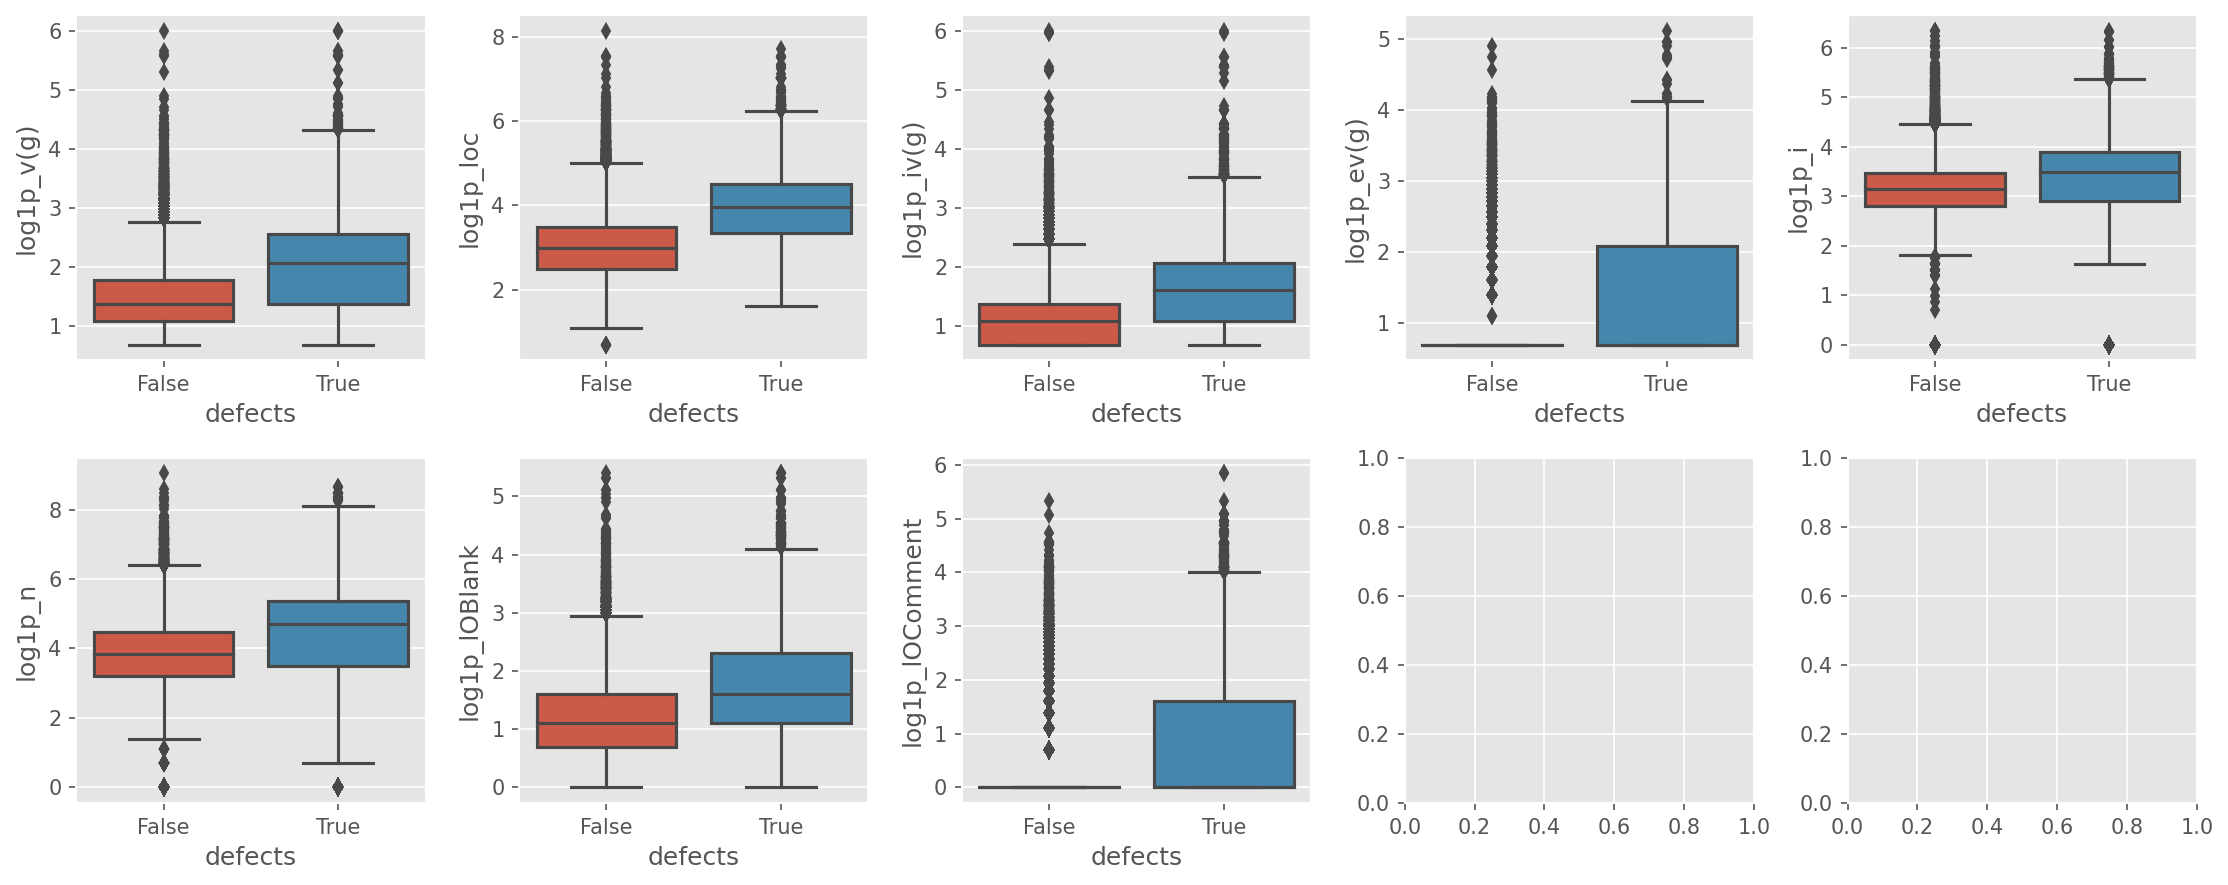

In [15]:
n_rows = 2
n_cols = 5
fig,axs = plt.subplots(n_rows,n_cols,figsize=(3*n_cols,3*n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_index = n_cols*i+j
        if col_index == len(numerical_features):
            break
            
        _ = sns.boxplot(data=train, y=numerical_features[col_index], x='defects', ax=axs[i,j])
        
fig.tight_layout()

### Preparing the features

In [16]:
X = train[numerical_features]
y = 1*train['defects'].values

## Catboost model

The function `fit_model` in the cell below, trains a catboost classification model. The function also allows the specification of hyperparameters as a dictionary through the `config` argument. If `config` is not specified, default values for the hyperparameters are used.

Since there is class imbalance, we apply the following weights for the classes:
$$
    \left[\frac{total}{2}*\frac{1}{neg},  \frac{total}{2}*\frac{1}{pos}\right],
$$

where neg and pos are the number of observations for `defects=False` and `defects=True` respectively in the training set, and total is the total number of observations.

In [17]:
def fit_model(
    X:pd.DataFrame,
    y:np.ndarray,
    config:Optional[Dict]=None,
    n_jobs:int=1,
    verbose:int=0,
    random_seed:int=100,
) -> CatBoostClassifier:
    '''
    Train a catboost classifier
    '''
    
    # add class weights to correct for imbalance
    neg, pos = np.bincount(y)
    total = y.shape[0]
    class_weights = [(total / neg) / 2.0, (total / pos) / 2.0]
    
    
    model = CatBoostClassifier(
        thread_count = n_jobs,
        random_seed = random_seed,
        verbose = verbose,
        class_weights = class_weights
    )
    
    if config:
        # if config is supplied, set the model hyperparameters
        model.set_params(**config)
        
    return model.fit(X, y)

In [18]:
model = fit_model(X, y, n_jobs=4, verbose=50, random_seed=100)
model.save_model('baseline.cbm',format='cbm')

Learning rate set to 0.074161
0:	learn: 0.6725643	total: 76.5ms	remaining: 1m 16s
50:	learn: 0.5514927	total: 848ms	remaining: 15.8s
100:	learn: 0.5490918	total: 1.65s	remaining: 14.6s
150:	learn: 0.5474240	total: 2.44s	remaining: 13.7s
200:	learn: 0.5445250	total: 3.3s	remaining: 13.1s
250:	learn: 0.5423544	total: 4.16s	remaining: 12.4s
300:	learn: 0.5401696	total: 4.94s	remaining: 11.5s
350:	learn: 0.5381026	total: 5.68s	remaining: 10.5s
400:	learn: 0.5358650	total: 6.46s	remaining: 9.64s
450:	learn: 0.5341642	total: 7.22s	remaining: 8.78s
500:	learn: 0.5324095	total: 8.03s	remaining: 8s
550:	learn: 0.5309531	total: 8.77s	remaining: 7.15s
600:	learn: 0.5293091	total: 9.51s	remaining: 6.31s
650:	learn: 0.5278205	total: 10.3s	remaining: 5.5s
700:	learn: 0.5265212	total: 11s	remaining: 4.68s
750:	learn: 0.5251704	total: 11.7s	remaining: 3.88s
800:	learn: 0.5236161	total: 12.5s	remaining: 3.1s
850:	learn: 0.5222092	total: 13.2s	remaining: 2.31s
900:	learn: 0.5209218	total: 14s	remaining:

### Cross-lvaidtion

To provide a numerical measure for the baseline, we will use the roc-auc estimate from 5-fold stratified cross-validation.

In [19]:
import warnings
from tqdm import tqdm
def fit_and_test_fold(X, y, train_index,test_index) -> float:
    X_train = X.iloc[train_index,:];X_test = X.iloc[test_index,:]
    y_train = y[train_index]; y_test = y[test_index]
    
    # fit model on training data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = fit_model(X_train, y_train, n_jobs=4)
    
    # generate predictions on test data
    test_prob = model.predict_proba(X_test)[:,1]
    
    return roc_auc_score(y_test, test_prob)


cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
cv_auc_scores = [None]*5
for i, (train_index, test_index) in tqdm(enumerate(cv.split(X,y))):
    cv_auc_scores[i] = fit_and_test_fold(X, y, train_index, test_index)

cv_auc = np.mean(cv_auc_scores)
print(f'CV ROC-AUC for baseline model: {cv_auc:.3f}')

5it [01:07, 13.58s/it]

CV ROC-AUC for baseline model: 0.787


In [20]:
# AUC scores for held-out folds - not too different
np.array(cv_auc_scores)

array([0.78691138, 0.78812826, 0.79083442, 0.79043862, 0.77891311])

### Feature importances

We now compute the gain based feature importance measures from the catboost model.

Notes:

 1. Feature importance measures from tree based models can be misleading.
 2. In catboost, the default feature importance measure is based on the total gain from splits involving the feature.


<Axes: >

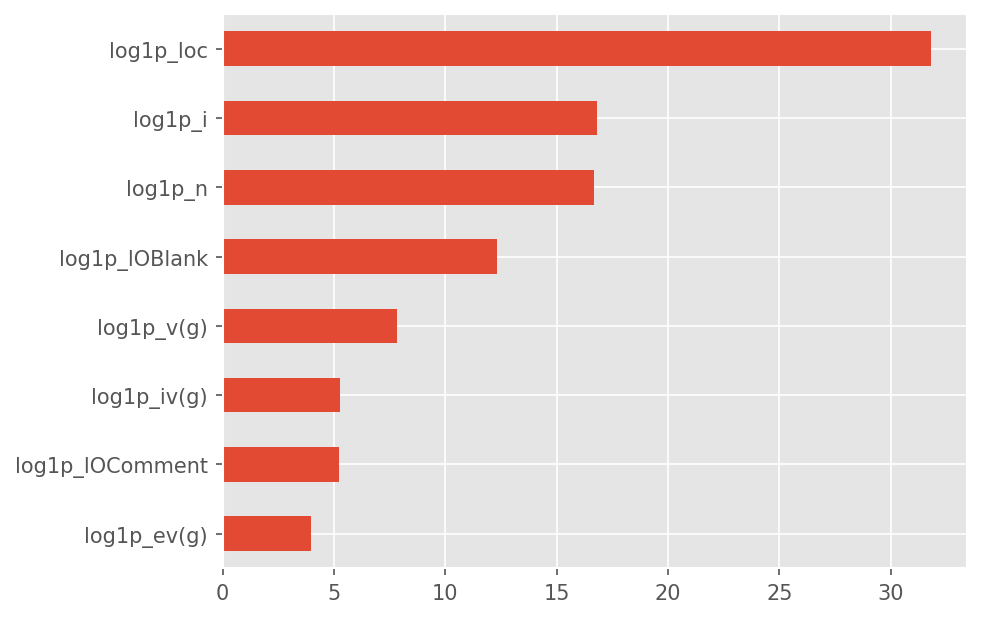

In [21]:
# gain based feature importances - not necessarily the most reliable
feat_imp = pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh')

## Feature importances through SHAP

The default feature importances computed by catboost (or any tree based model) can be misleading. Here, we will use SHAP measures to check the importance of each feature. SHAP values represent the impact of each feature on the model's output.

In [22]:
%%time 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

CPU times: user 30.4 s, sys: 600 ms, total: 31 s
Wall time: 9.26 s


In the SHAP summary plot, we plot a horizontal bar plot of the absolute SHAP value for each feature averaged across the observations. Features with longer bars have a higher influence on the model's output. It turns out the there is not a lot of difference in ordering between the SHAP importances and the gain based feature importances:  `log1p_loc` is the most important feature by a distance

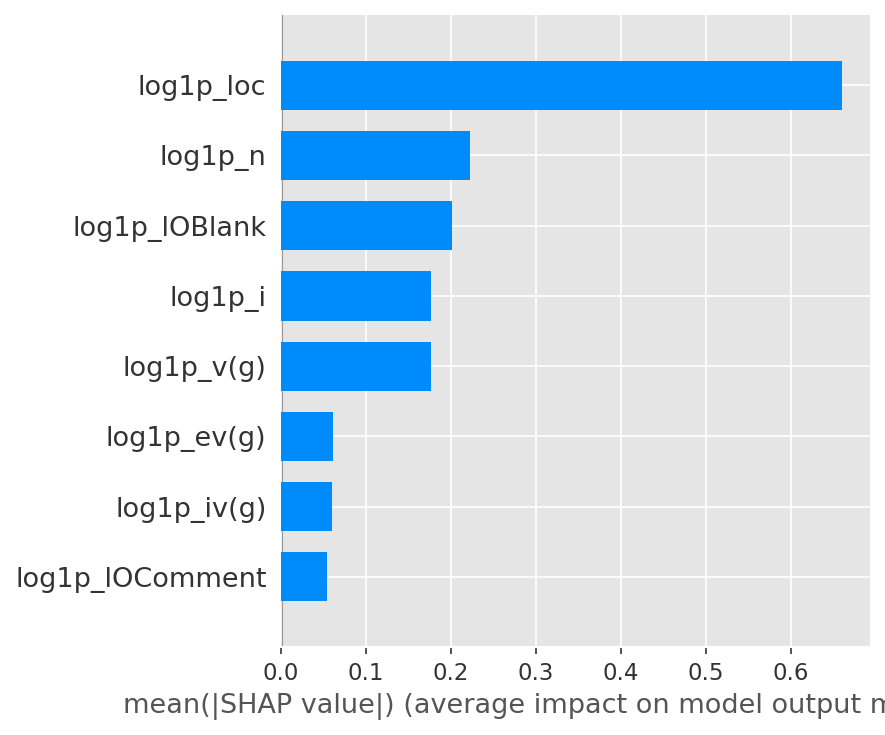

In [23]:
# Average of SHAP value magnitudes across the dataset
shap.summary_plot(
    shap_values, X, plot_type="bar",
    plot_size = (6,5)
)

## ALE Plots

Alternatively, we can visualize the effects of the individual predictors using ALE plots (https://academic.oup.com/jrsssb/article/82/4/1059/7056085). The ALE plots can be used for

1. interpreting the individual effects of the predictors - e.g.: linear vs non-linear, monotonic vs non-monotonic, quadratic, etc.
2. determining the most influential predictors. The influence can be estimated through the range of y-axis values in each plot. The larger the range, the larger the effect.

Unlike partial dependence plots, ALE plots are not sensitive to correlations between pairs of descriptors

For binary classification problems, we will generate ALE plots for the predicted log-odds. If all the first-order ALE profiles for the log-odds are linear, then perhaps a logistic regression model can capture the dependencies better.

In [24]:
from functools import partial
def predict_log_odds(data:pd.DataFrame,model) -> np.ndarray:
    '''
    Convenience prediction to generate predicted log odds from 
    an estimator with scikit-learn API
    '''
    probs = np.clip(model.predict_proba(data)[:,-1],1e-6,1-1e-6)
    return np.log(probs) - np.log(1-probs)

model_log_odds = partial(predict_log_odds,model=model)

We will be using the `alepython` library for generating ALE plots. The library is not posted to the offical PyPi repository, but is available from Github (https://github.com/blent-ai/ALEPython). Run the code cell below to install the library.

In [25]:
# install alepython library for visualizing feature effects
!pip install git+https://github.com/MaximeJumelle/ALEPython.git

  Cloning https://github.com/MaximeJumelle/ALEPython.git to /tmp/pip-req-build-tw6jf8n7
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-req-build-tw6jf8n7
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.9 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350a-py3-none-any.whl size=15019 sha256=f313688fe5b28e1550ee896eac107ff37e58edb9cf14f95a1e9d786516e323d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-9w5fy7qz/wheels/7d/48/b5/9c2e59d29533d22640d0b3e038a5fa7d3bc26e8cfbb14e5cfe
Successfully built alepython


The default plot function from this library has limited customizability. We will instead manually extract and plot the computed ALE values. The hidden cell below contains utility scripts for generating the 1st order ALE effects.

In [26]:
from alepython.ale import _first_order_ale_quant
from typing import Callable,Iterable,Union


def first_order_aleplot_quant(
    predictor:Callable,
    train_data:pd.DataFrame,
    feature:str,
    ax:plt.Axes,
    bins:int=10,
    **kwargs):
    '''
    Plot and return the first-order ALE function for a continuous feature.

    Arguments
    ---------
    predictor: callable
        The prediction function. For scikit-learn regressors, pass the `.predict`
        method. For scikit-learn classifiers, either pass the `.predict_proba` method
        or pass a custom log-odds function. For other pass a custom predict function
        that takes in a pandas dataframe as input
    
    train_data: pd.DataFrame
        Training data on which the model was trained. Cannot pass numpy ndarrays.
    
    feature: str
        Feature name. A single column label
    
    ax: matplotlib.axes.Axes
        Pre-existing axes to plot onto
    
    bins : int
        This defines the number of bins to compute. The effective number of bins may
        be less than this as only unique quantile values of train_data[feature] are
        used.
    
    **kwargs: plot properties, optional
        Additional keyword parameters passed to `ax.plot`.
    
    Returns
    ---------
    ax: matplotlib.axes.Axes
        The matplotlib axes containing the plot
    
    ale: np.ndarray
        first order ALE
    
    quantiles: np.ndarray
        The quantiles used
    '''

    ale,quantiles = _first_order_ale_quant(predictor,train_data,feature,bins)
    bin_centers = 0.5*(quantiles[:-1]+quantiles[1:])
    _ = ax.plot(bin_centers,ale,**kwargs)
    _ = sns.rugplot(train_data[feature],ax=ax,color='k',alpha=0.2)
    _ = ax.grid(linestyle="-", alpha=0.5)
    _ = ax.set_xlabel(feature)
    _ = ax.set_ylabel(r'$f_1$(%s)'%feature)
    return ax,ale,quantiles

The first order ALE plots for the selected features are shown below. The importance of a feature can be deduced from the range of the y-axis in its corresponding ALEPlot. The order of feature importance:

`log1p_loc` >> `log1p_n` > `log1p_iv(g)`,  `log1p_i`, `log1p_IOBlank` > `log1p_ev(g)` > `log1p_v(g)` >>  `log1p_IOComment`

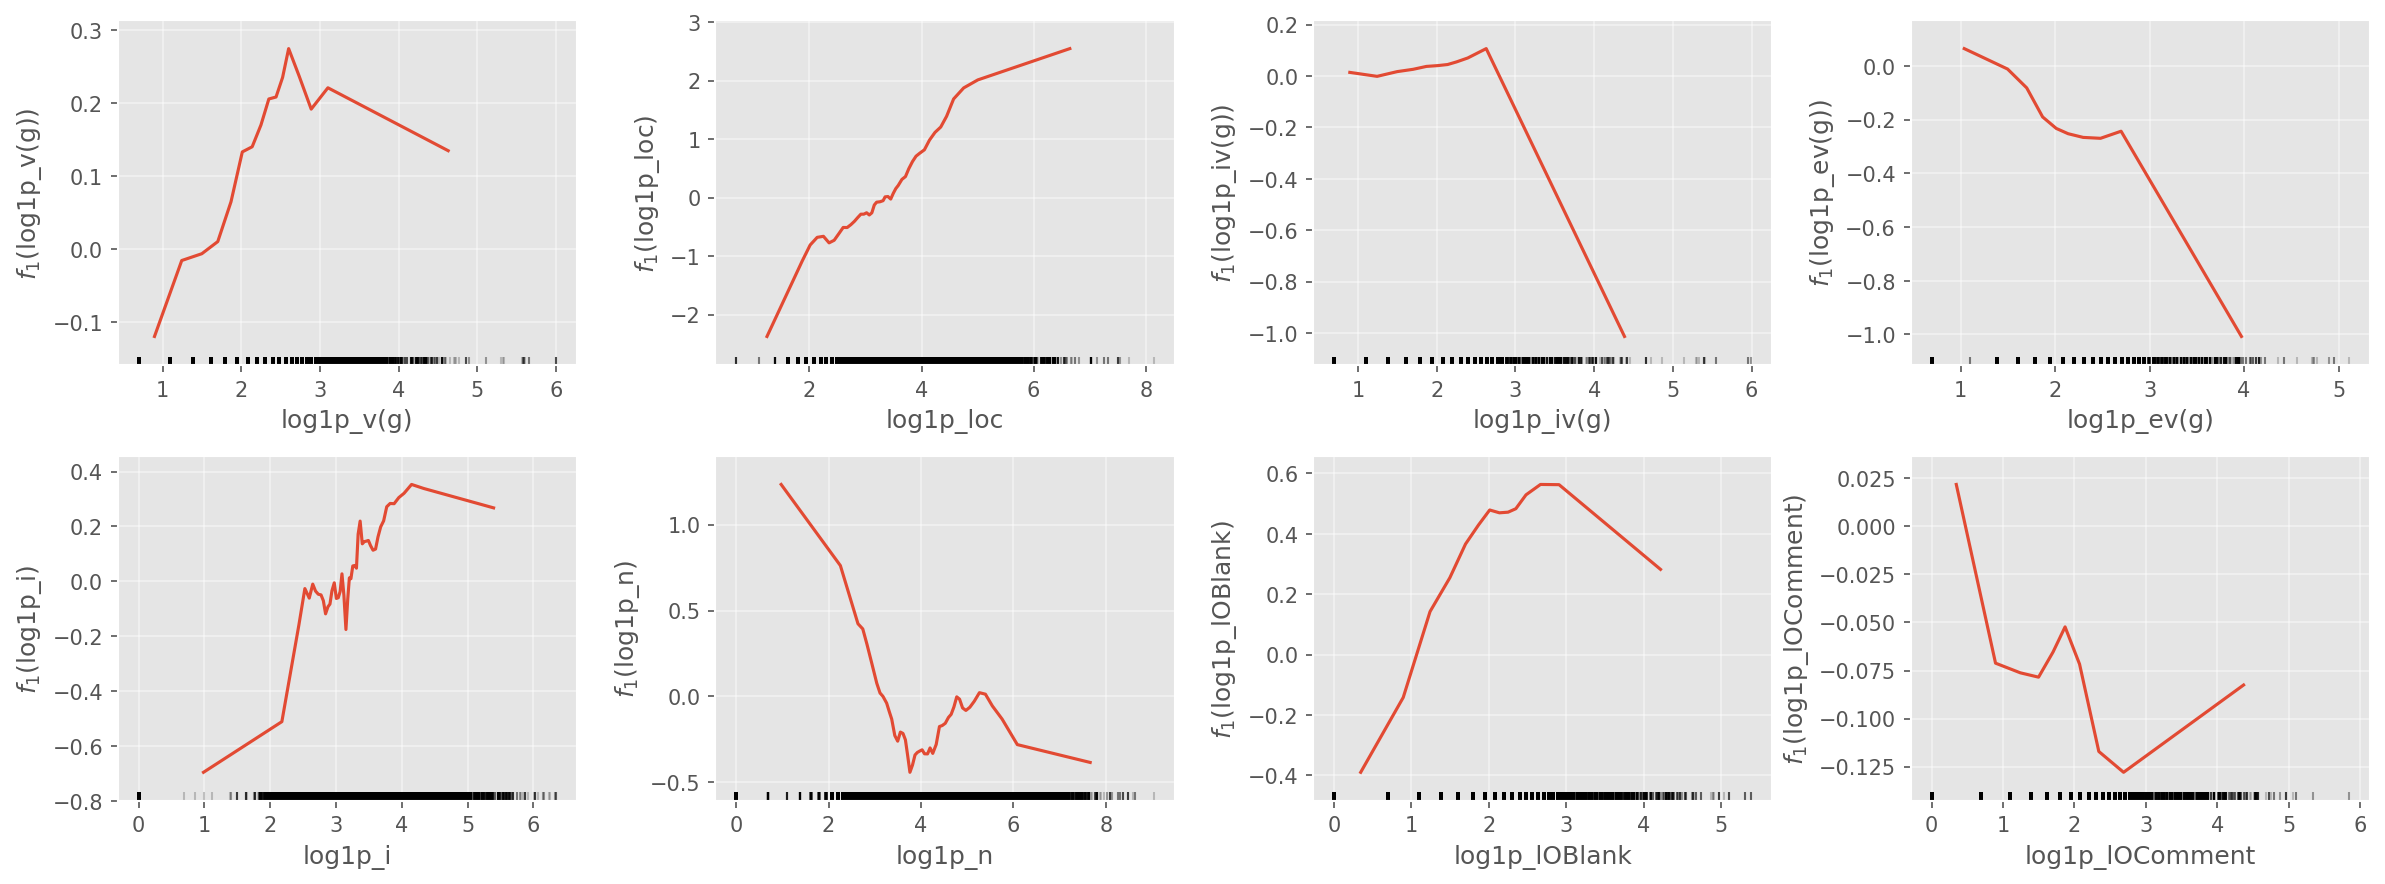

In [27]:
n_rows = 2
n_cols = 4
fig,axs = plt.subplots(n_rows,n_cols,figsize=(4*n_cols, 3*n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        feature = X.columns[n_cols * i + j]
        _ = first_order_aleplot_quant(model_log_odds, X, feature, bins=50, ax=axs[i,j])
        
fig.tight_layout()

# save the plots
fig.savefig('ale_log_odds.png',bbox_inches='tight')
fig.savefig('ale_log_odds.pdf',bbox_inches='tight')

## Test predictions

In [28]:
# prepare test data
test = test.drop(high_mode_per.index.tolist(), axis=1)

test[numerical_cols] = test[numerical_cols].apply(np.log1p)
test = test.rename({col:f'log1p_{col}' for col in numerical_cols}, axis=1)

test = test[numerical_features]

submission = pd.DataFrame({
    'id':test.index.values,
    'defects': model.predict_proba(test)[:,1]
})
submission.to_csv('submission.csv',index=False)